# Extract a section from the NSIDC sea ice clim

#### download from here: https://nsidc.org/data/NSIDC-0192/versions/3

In [8]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
# https://gis.stackexchange.com/questions/97828/reading-zipped-esri-bil-files-with-python
def ReadBilFile(bil):
    import gdal
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(bil)
    band = img.GetRasterBand(1)
    data = band.ReadAsArray()
    return data

#### rename file to "mean.sep.1979-2020.s.bil" , create header file below (https://nsidc.org/support/22256950-How-do-I-import-the-sea-ice-trends-data-into-ArcGIS-)

In [3]:
%%bash

cat > mean.sep.1979-2020.s.hdr <<END
nrows 332

ncols 316

nbands 1

nbits 8

layout bil

byteorder I

ulxmap -3937500

ulymap 4337500

xdim 25000

ydim 25000
END

In [5]:
ls mean.sep*bil mean.sep*hdr

mean.sep.1979-2020.s.bil  mean.sep.1979-2020.s.hdr


In [ ]:
a = ReadBilFile('mean.sep.1979-2020.s.bil')

In [5]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 

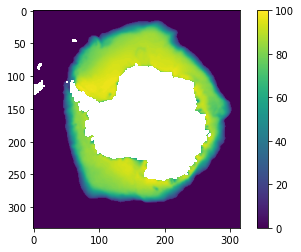

In [6]:
# quick look
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()

#### find the indices for a section in the bitmap with NSIDCs python tools

In [114]:
!git clone https://github.com/nsidc/polar_stereo.git

Klone nach 'polar_stereo' ...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139
Empfange Objekte: 100% (139/139), 29.47 MiB | 7.48 MiB/s, Fertig.
Löse Unterschiede auf: 100% (74/74), Fertig.


cd polar_stereo/source/

#### nsidc_polar_lonlat should do the job, use nsidc_polar_ij as a check

In [8]:
from polar_convert import polar_xy_to_lonlat
import numpy as np


def nsidc_polar_ij(i, j, grid, hemisphere):
    """Transform from NSIDC Polar Stereographic I, J coordinates
    to longitude and latitude coordinates
    
    Args:
        i (int): an integer or integer array giving the x grid coordinate(s)
        j (int): an integer or integer array giving the y grid coordinate(s)
        grid (float): 6.25, 12.5 or 25; the grid cell dimensions in km
        hemisphere (1 or -1): Northern or Southern hemisphere
    
    Returns:
        If i and j are scalars then the result is a
        two-element list containing [longitude, latitude].
        If i and j are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.

    Examples:
        print(nsidc_polar_ij(608, 896, 12.5, 1))
            [350.01450147320855, 34.40871032516291]
    """

    true_scale_lat = 70
    re = 6378.273
    e = 0.081816153

    if grid != 6.25 and grid != 12.5 and grid != 25:
        raise ValueError("Legal grid values are 6.25, 12.5, or 25")
    
    if hemisphere != 1 and hemisphere != -1:
        raise ValueError("Legal hemisphere values are 1 or -1")

    if hemisphere == 1:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid/2
        ymin = -5350 + grid/2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid/2
        ymin = -3950 + grid/2

    if grid == 12.5:
        imax = imax//2
        jmax = jmax//2
    elif grid == 25:
        imax = imax//4
        jmax = jmax//4

    if np.any(np.less(i, 1)) or np.any(np.greater(i, imax)):
        raise ValueError("'i' value is out of range: [1, " + str(imax) + "]")
    if np.any(np.less(j, 1)) or np.any(np.greater(j, jmax)):
        raise ValueError("'j' value is out of range: [1, " + str(jmax) + "]")

    # Convert I, J pairs to x and y distances from origin.
    x = ((i - 1)*grid) + xmin
    y = ((jmax - j)*grid) + ymin
    lonlat = polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere)
    lon = lonlat[0] - delta
    lon = lon + np.less(lon, 0)*360
    return [lon, lonlat[1]]

In [9]:
import numpy as np
from polar_convert import polar_lonlat_to_xy


def nsidc_polar_lonlat(longitude, latitude, grid, hemisphere):
    """Transform from geodetic longitude and latitude coordinates
    to NSIDC Polar Stereographic I, J coordinates
    
    Args:
        longitude (float): longitude or longitude array in degrees
        latitude (float): latitude or latitude array in degrees (positive)
        grid (float): 6.25, 12.5 or 25; the grid cell dimensions in km
        hemisphere (1 or -1): Northern or Southern hemisphere
    
    Returns:
        If longitude and latitude are scalars then the result is a
        two-element list containing [I, J].
        If longitude and latitude are numpy arrays then the result will
        be a two-element list where the first element is a numpy array for
        the I coordinates and the second element is a numpy array for
        the J coordinates.

    Examples:
        print(nsidc_polar_lonlat(350.0, 34.41, 12.5, 1))
            [608, 896]
    """

    true_scale_lat = 70
    re = 6378.273
    e = 0.081816153

    if grid != 6.25 and grid != 12.5 and grid != 25:
        raise ValueError("Legal grid value are 6.25, 12.5, or 25")
    
    if hemisphere >= 0:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid/2
        ymin = -5350 + grid/2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid/2
        ymin = -3950 + grid/2

    if grid == 12.5:
        imax = imax//2
        jmax = jmax//2
    elif grid == 25:
        imax = imax//4
        jmax = jmax//4

    xy = polar_lonlat_to_xy(longitude + delta, np.abs(latitude),
                            true_scale_lat, re, e, hemisphere)
    i = (np.round((xy[0] - xmin)/grid)).astype(int) + 1
    j = (np.round((xy[1] - ymin)/grid)).astype(int) + 1
    # Flip grid orientation in the 'y' direction
    j = jmax - j + 1
    return [i, j]

#### Define a section here:

In [86]:
NSIDC_lats=np.arange(50.,90.,1.)  # 60°S to 90°S, in 0.5 steps
NSIDC_lons=-30.*np.ones_like(NSIDC_lats) # section along 30°W
hemisphere=-1 # Southern Hemisphere
grid=25 # res is 25km

In [87]:
# find the right pixels
NSIDC_section_idx=nsidc_polar_lonlat(longitude=NSIDC_lons, latitude=NSIDC_lats, grid=grid, hemisphere=hemisphere)
NSIDC_section_idx

[array([ 68,  71,  73,  76,  78,  80,  83,  85,  87,  90,  92,  94,  97,
         99, 101, 103, 106, 108, 110, 113, 115, 117, 119, 121, 124, 126,
        128, 130, 132, 135, 137, 139, 141, 143, 145, 148, 150, 152, 154,
        156]),
 array([ 18,  22,  27,  31,  35,  39,  43,  47,  51,  55,  59,  63,  67,
         71,  75,  79,  83,  87,  91,  95,  99, 103, 106, 110, 114, 118,
        122, 126, 129, 133, 137, 141, 144, 148, 152, 156, 159, 163, 167,
        171])]

In [88]:
# transform back, looks more or less ok
nsidc_polar_ij(i=NSIDC_section_idx[0], j=NSIDC_section_idx[1], grid=grid, hemisphere=hemisphere)

[array([329.96028882, 330.15406805, 329.90080228, 330.10484911,
        330.01243491, 329.91475174, 330.13794958, 330.0378159 ,
        329.93141718, 330.17772688, 330.06848816, 329.95167735,
        330.22642778, 330.10629883, 329.97683594, 329.83690876,
        330.15406805, 330.00891368, 329.8503383 , 330.21632671,
        330.05121999, 329.86828136, 330.03043052, 329.82647997,
        330.30613897, 330.09157268, 329.84545208, 329.56027562,
        329.78272604, 330.47863817, 330.17291535, 329.79676225,
        330.15406805, 329.67639314, 329.03624347, 330.42216132,
        331.26020471, 330.524111  , 329.03624347, 324.46232221]),
 array([-49.93058245, -50.94919899, -52.05010438, -53.08171321,
        -54.01463801, -54.95227045, -56.00043512, -56.94803554,
        -57.90005138, -58.96377829, -59.92514521, -60.89060309,
        -61.96878775, -62.94291874, -63.92078467, -64.90225217,
        -65.99801713, -66.98716939, -67.97952382, -69.08682381,
        -70.08605991, -71.0880686 , -7

#### check where the section lies

In [89]:
NSIDC_section_idx=np.array(NSIDC_section_idx)

In [90]:
NSIDC_section_idx=NSIDC_section_idx[[1,0],:] # switch i and j
NSIDC_section_idx

array([[ 18,  22,  27,  31,  35,  39,  43,  47,  51,  55,  59,  63,  67,
         71,  75,  79,  83,  87,  91,  95,  99, 103, 106, 110, 114, 118,
        122, 126, 129, 133, 137, 141, 144, 148, 152, 156, 159, 163, 167,
        171],
       [ 68,  71,  73,  76,  78,  80,  83,  85,  87,  90,  92,  94,  97,
         99, 101, 103, 106, 108, 110, 113, 115, 117, 119, 121, 124, 126,
        128, 130, 132, 135, 137, 139, 141, 143, 145, 148, 150, 152, 154,
        156]])

In [91]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 
a_masked[tuple(NSIDC_section_idx)]=200

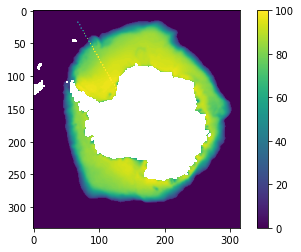

In [92]:
# this is the correct section at 30W
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()

#### plot the section

In [93]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 
section30w=a_masked[tuple(NSIDC_section_idx)]

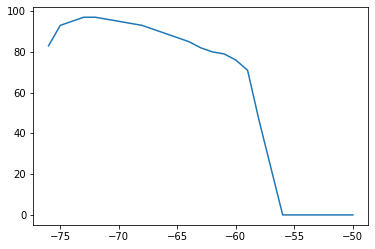

In [94]:
plt.plot(-NSIDC_lats, section30w)

In [95]:
def determine_extent_lat(zz_area, lats):
    
    maxlat=np.nanmax(lats[zz_area[:]>0.15])
    
    xp=[maxlat+1.,maxlat] # maxlat+1. is equal or below 0.15
    fp=[zz_area[lats==maxlat+1].data[0], zz_area[lats==maxlat].data[0]]

    return np.interp(0.15, fp, xp)

In [96]:
determine_extent_lat(section30w/100., -NSIDC_lats)

-56.65217391304348

In [102]:
from matplotlib import cm
import matplotlib.colors as mcol
import numpy.matlib
from matplotlib.backends.backend_pdf import PdfPages

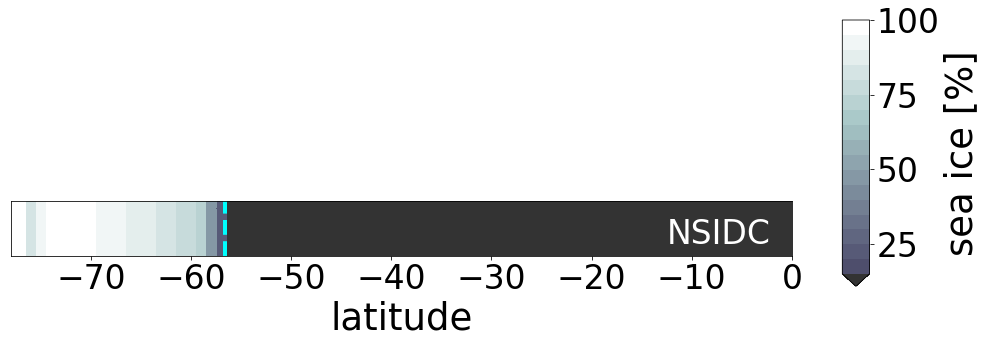

In [110]:
fig, ax = plt.subplots(figsize=(14,1))

lvIce = np.linspace(0.35,1.0,17) #12
cmIce = cm.bone(lvIce)
newCmap = mcol.ListedColormap(cmIce)

newCmap.set_under('0.2')

# set sizes
numfontsize=33
texfontsize=37

which='NSIDC'
NSIDCextent=determine_extent_lat(section30w/100., -NSIDC_lats)

X=-NSIDC_lats
Z=section30w

Y=np.arange(0,5)
Yrep=np.matlib.repmat(Y, np.shape(NSIDC_lats)[0], 1).T

im=plt.pcolor(np.array([X,X,X,X,X]),Yrep, np.array([Z,Z,Z,Z,Z]), cmap=newCmap, vmin=15., vmax=100., shading='nearest')

plt.vlines(NSIDCextent, 0., 4., color='cyan', linewidths=4, linestyle='dashed')
plt.axis([-78., 0., 0., 4.]);

# tick sizes
plt.xticks(fontsize=numfontsize, rotation=0);
plt.yticks(fontsize=numfontsize, rotation=0);

plt.xlabel('latitude',fontsize=texfontsize);
ax.axes.yaxis.set_visible(False)
ax.set_facecolor('0.2')

# annotation
plt.annotate(which, xy=(0.84, 0.22), xycoords='axes fraction', backgroundcolor = 'none', color='w', fontsize=33)

# Now adding the colorbar
cbaxes = fig.add_axes([.95, -.3, 0.027, 3.7]) 
cbar = plt.colorbar(im, orientation = 'vertical', cax = cbaxes, extend='min')  

cbar_label='sea ice [%]'
cbar.set_label(cbar_label, fontsize=texfontsize)
cbar.ax.tick_params(labelsize=numfontsize) 

#plt.tight_layout()

saveFIG=True
if saveFIG==True:
   pp = PdfPages('./Figure4a_ice.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()